# Demonstration of `photutils.psf` with NIRCam Simulated Data

*Important Note*: There's a bug in the oversampling code that makes the second part of this notebook fail if you use v0.3 of photutils.  

Depending on when you're looking at this, you might need to grab either a newer version or the in-development version of photutils.  The easiest way to do this is to do the below.  Be sure you're in a dev environment before doing this, though (e.g. `source activate jwst-workshop`)

``pip install git+https://github.com/astropy/photutils.git#egg=photutils``

In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy import wcs

%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
import photutils
from photutils import psf
from astropy.modeling import models

photutils.__version__

'0.3.1'

# Simulated NIRCam data 

Using NIRCam simulated data of 47 Tuc from Bryan Hilbert, created March 2017. This is data that is being used to test the pipeline so it includes the relevant noise, distortion, wcs, ...

In [5]:
# you might need to change this depending on where you've put
# the dataset 

im1fn = '/astro/3/jwst_da_sprint_testdata/photometry_III/NIRCamSimData/Hilbert_47Tuc/nrca1_47Tuc_subpix_dither1_newpos_cal.fits'
psf1fn = '/astro/3/jwst_da_sprint_testdata/photometry_III/NIRCamSimData/Hilbert_47Tuc/nircam_f115w_115_0_0p0_0p0.fits'
# This PSF is centered on a pixel. Simulted image was created using 0.1 pixel offsets 
# and the PSF that's added is the one nearest the requested star position.


In [6]:
im1f = fits.open(im1fn)
im1 = im1f[1].data
im1h = im1f[2].header #Had to use ext 2 b/c problem with where pipeline puts WCS
im1wcs = wcs.WCS(im1h)


psf1f = fits.open(psf1fn)
psf1 = psf1f[0].data
psf1h = psf1f[0].header
psf1wcs = wcs.WCS(psf1h)



In [20]:
# this is a quick-and-easy way to re-scale an image, using the 
# astropy.visualization package
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

viz = LogStretch() + ManualInterval(vmin=-1,vmax=200)
viz2 = LogStretch() + PercentileInterval(99)


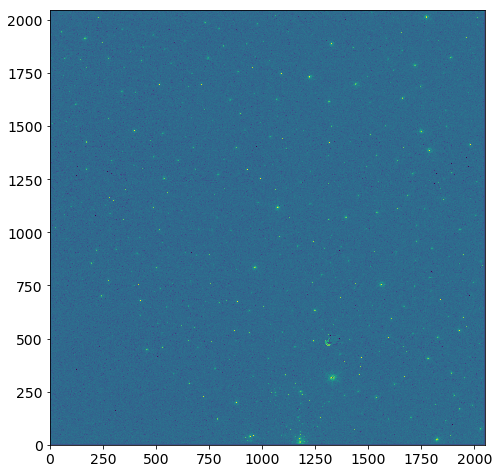

In [21]:
plt.imshow(viz(im1))

OK, lets histogram it so we can see roughly where the threshold should be

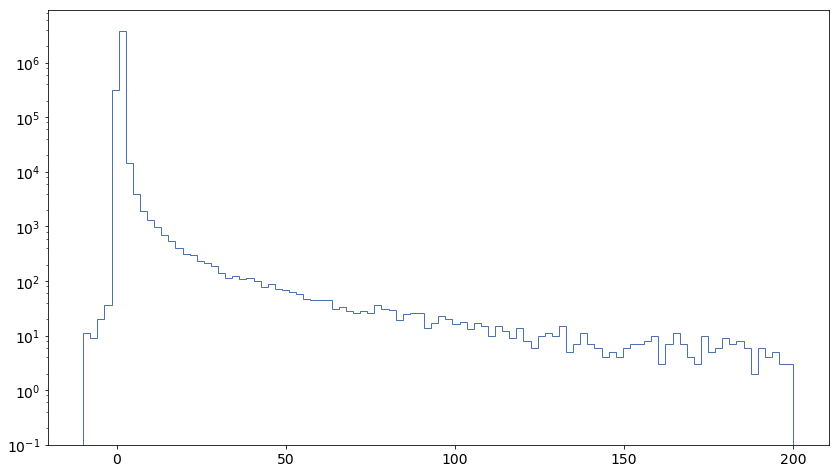

In [22]:
plt.hist(im1.ravel(), bins=100, histtype='step', range=(-10, 200), log=True)
None

In [23]:
dsf = photutils.DAOStarFinder(3, 3)
found_stars = dsf(im1)
found_stars['xcentroid'].name = 'x_0'
found_stars['ycentroid'].name = 'y_0'
found_stars['flux'].name = 'flux_0'
found_stars

id,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux_0,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1175.51587785,5.21720342376,0.47369630139,-0.145964102749,-0.36348173825,25.0,0.0,24.0883522034,5.92817910789,-1.93230329124
2,1178.27041825,5.40744832887,0.586374366273,0.0219822778055,-0.413860899547,25.0,0.0,11.6449384689,1.8250926057,-0.653212263934
3,1182.22576391,5.92951575898,0.583860040549,-0.344093771799,0.353882147849,25.0,0.0,15.4997797012,2.91058402984,-1.15995035519
4,1169.46194938,8.34693969349,0.415613249429,0.062333411107,0.482514669329,25.0,0.0,11.0082025528,1.76485007012,-0.616769541329
5,1179.29296647,9.37213109978,0.603722030719,0.988714920317,0.524626730933,25.0,0.0,22.2594661713,3.53867065324,-1.372100361
6,1183.71902872,8.55649084262,0.386682975189,0.290549481159,-0.658208938398,25.0,0.0,14.7872819901,2.81678007171,-1.12438234876
7,1170.96049797,13.7067518187,0.253440762215,0.512374253964,-0.370264825292,25.0,0.0,15.6760349274,3.51210593751,-1.36391901821
8,1067.77449772,13.5342187636,0.737540737977,-0.187922624474,0.30738493552,25.0,0.0,10.4325876236,2.58781330262,-1.03233235255
9,1166.74744232,12.0851807469,0.507684823195,-0.324177274227,-0.887304498369,25.0,0.0,10.2668113708,1.38082262521,-0.350344736202


(500, 1500)

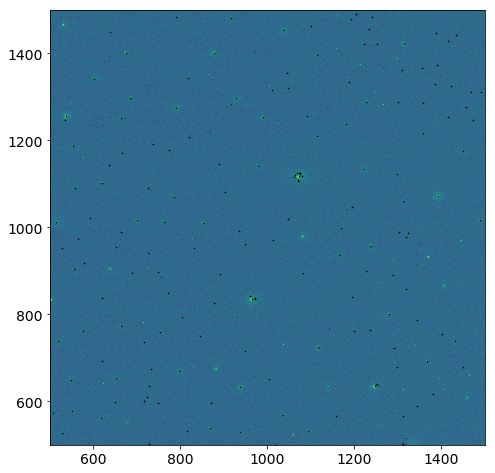

In [24]:
plt.imshow(viz(im1))
plt.scatter(found_stars['x_0'], found_stars['y_0'], lw=0, s=3, c='k')
plt.xlim(500, 1500)
plt.ylim(500, 1500)

Now we build the actual PSF model using the file that the PSF is given in. It is using external knowledge that the PSF is 5x oversampled. The simple oversampling below only works as-is because both are square, but that's true here.

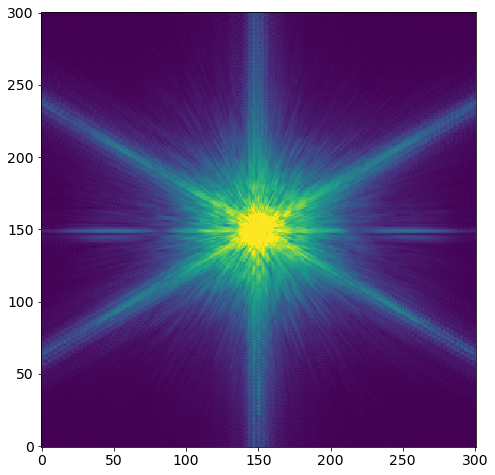

In [25]:
# note that this is *not* the same pixel scale as the image above
plt.imshow(viz2(psf1))

psfmodel = psf.FittableImageModel(psf1, oversampling=1) 

Lets now zoom in on the image somewhere and see how the model looks compared to the actual image scale

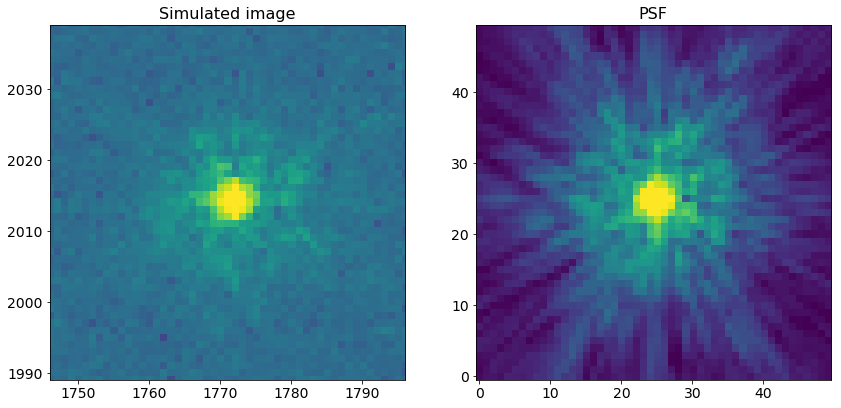

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(viz(im1))
ax1.set_xlim(1771-25,1771+25)
ax1.set_ylim(2014-25,2014+25)
ax1.set_title('Simulated image')

xg, yg = np.mgrid[-25:25, -25:25]
ax2.imshow(viz2(psfmodel(xg, yg)))
ax2.set_title('PSF')

Now we build a PSF photometry runner that is auto-configured to work basically the same as DAOPHOT.  All of the steps in photometry are customizable if you like, but for now we'll just use this because it's a familiar code to many people. 

In [27]:
psfphot = psf.DAOPhotPSFPhotometry(crit_separation=5, 
                                   threshold=5, fwhm=2, 
                                   psf_model=psfmodel, fitshape=(13,13),
                                   niters=1, aperture_radius=5)
results = psfphot(im1, found_stars[:100])
results

id_1,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux_0,mag,id_2,group_id,x_fit,y_fit,flux_fit,iter_detected,id
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int64,int32
1,1175.51587785,5.21720342376,0.47369630139,-0.145964102749,-0.36348173825,25.0,0.0,24.0883522034,5.92817910789,-1.93230329124,1,1,1175.58779379,5.56031224678,134.224167276,1,--
2,1178.27041825,5.40744832887,0.586374366273,0.0219822778055,-0.413860899547,25.0,0.0,11.6449384689,1.8250926057,-0.653212263934,2,1,1185.18754108,13.5311531504,131.569185424,1,--
3,1182.22576391,5.92951575898,0.583860040549,-0.344093771799,0.353882147849,25.0,0.0,15.4997797012,2.91058402984,-1.15995035519,3,1,1182.3908976,4.54412128446,74.7586878227,1,--
4,1169.46194938,8.34693969349,0.415613249429,0.062333411107,0.482514669329,25.0,0.0,11.0082025528,1.76485007012,-0.616769541329,5,1,1175.76719525,17.3358270394,343.410721316,1,--
5,1179.29296647,9.37213109978,0.603722030719,0.988714920317,0.524626730933,25.0,0.0,22.2594661713,3.53867065324,-1.372100361,6,1,1180.56195604,7.52746250697,132.909436275,1,--
6,1183.71902872,8.55649084262,0.386682975189,0.290549481159,-0.658208938398,25.0,0.0,14.7872819901,2.81678007171,-1.12438234876,10,1,1177.15666305,13.7272021655,15118.6347293,1,--
7,1170.96049797,13.7067518187,0.253440762215,0.512374253964,-0.370264825292,25.0,0.0,15.6760349274,3.51210593751,-1.36391901821,4,2,1179.0985069,6.87001762433,3733.9870947,1,--
8,1067.77449772,13.5342187636,0.737540737977,-0.187922624474,0.30738493552,25.0,0.0,10.4325876236,2.58781330262,-1.03233235255,7,2,1123.18305307,235.59408021,320.367109311,1,--
9,1166.74744232,12.0851807469,0.507684823195,-0.324177274227,-0.887304498369,25.0,0.0,10.2668113708,1.38082262521,-0.350344736202,9,2,1175.9647981,12.8122855089,1406.51065168,1,--


Now lets inspect the residual image as a whole, and zoomed in on a few particular stars.

id_1,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux_0,mag,id_2,group_id,x_fit,y_fit,flux_fit,iter_detected,id
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int64,int32
1,1175.51587785,5.21720342376,0.47369630139,-0.145964102749,-0.36348173825,25.0,0.0,24.0883522034,5.92817910789,-1.93230329124,1,1,1175.58779379,5.56031224678,134.224167276,1,--
2,1178.27041825,5.40744832887,0.586374366273,0.0219822778055,-0.413860899547,25.0,0.0,11.6449384689,1.8250926057,-0.653212263934,2,1,1185.18754108,13.5311531504,131.569185424,1,--
3,1182.22576391,5.92951575898,0.583860040549,-0.344093771799,0.353882147849,25.0,0.0,15.4997797012,2.91058402984,-1.15995035519,3,1,1182.3908976,4.54412128446,74.7586878227,1,--
4,1169.46194938,8.34693969349,0.415613249429,0.062333411107,0.482514669329,25.0,0.0,11.0082025528,1.76485007012,-0.616769541329,5,1,1175.76719525,17.3358270394,343.410721316,1,--
5,1179.29296647,9.37213109978,0.603722030719,0.988714920317,0.524626730933,25.0,0.0,22.2594661713,3.53867065324,-1.372100361,6,1,1180.56195604,7.52746250697,132.909436275,1,--
6,1183.71902872,8.55649084262,0.386682975189,0.290549481159,-0.658208938398,25.0,0.0,14.7872819901,2.81678007171,-1.12438234876,10,1,1177.15666305,13.7272021655,15118.6347293,1,--
7,1170.96049797,13.7067518187,0.253440762215,0.512374253964,-0.370264825292,25.0,0.0,15.6760349274,3.51210593751,-1.36391901821,4,2,1179.0985069,6.87001762433,3733.9870947,1,--
8,1067.77449772,13.5342187636,0.737540737977,-0.187922624474,0.30738493552,25.0,0.0,10.4325876236,2.58781330262,-1.03233235255,7,2,1123.18305307,235.59408021,320.367109311,1,--
9,1166.74744232,12.0851807469,0.507684823195,-0.324177274227,-0.887304498369,25.0,0.0,10.2668113708,1.38082262521,-0.350344736202,9,2,1175.9647981,12.8122855089,1406.51065168,1,--


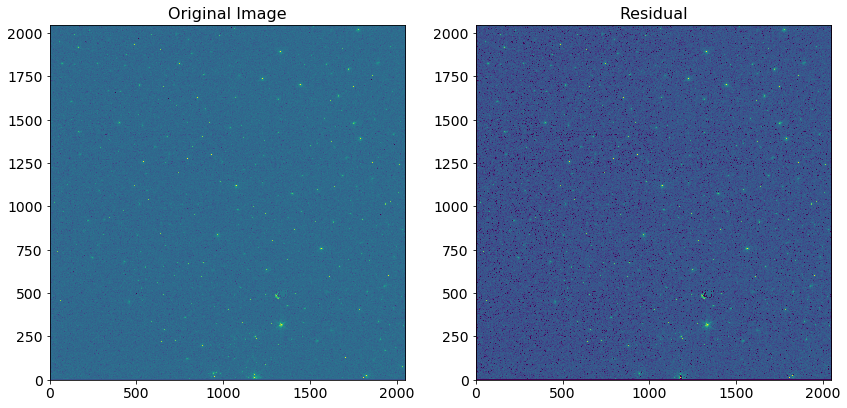

In [31]:
res_im1 = psfphot.get_residual_image()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(viz(res_im1))
ax1.imshow(viz(im1))
ax2.set_title('Residual')
ax1.set_title('Original Image')
results

5


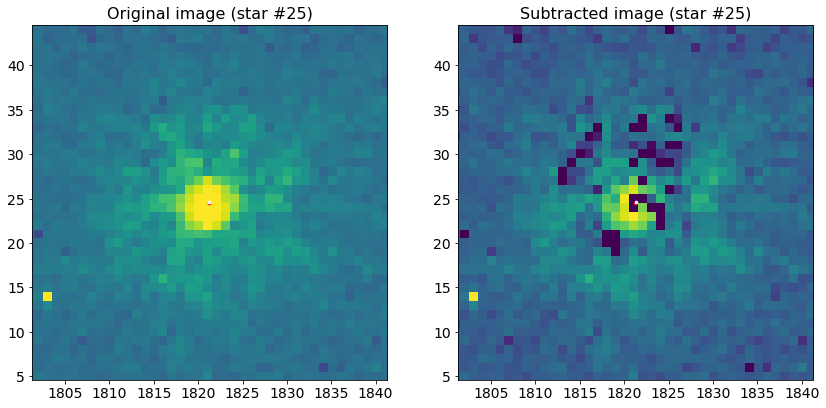

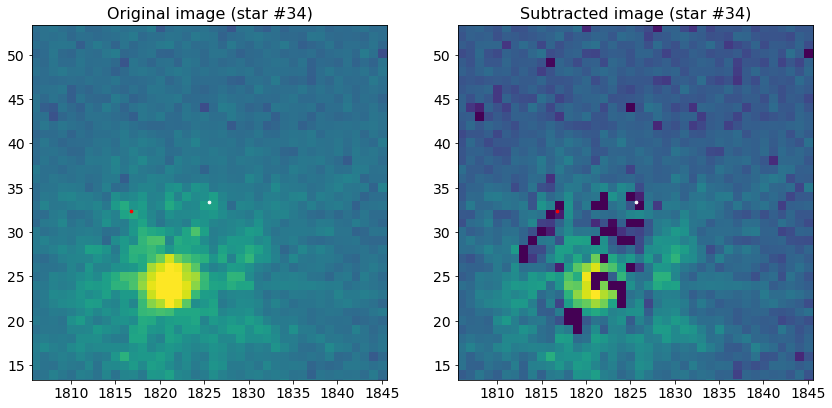

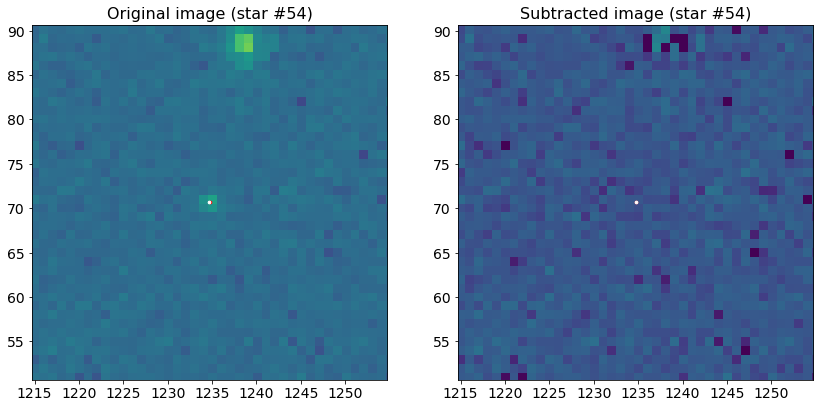

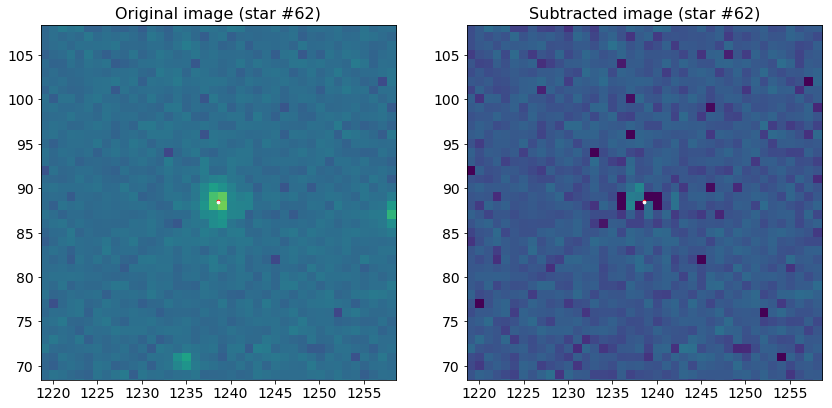

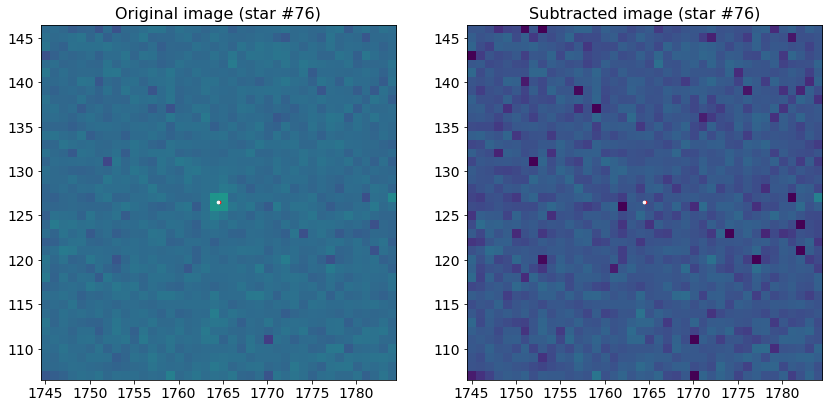

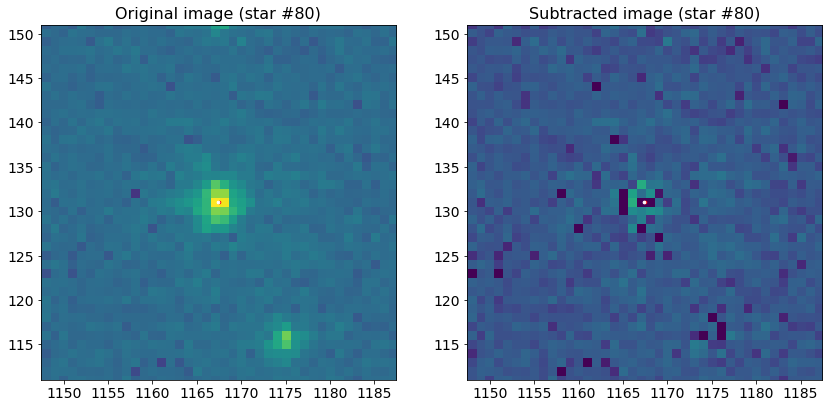

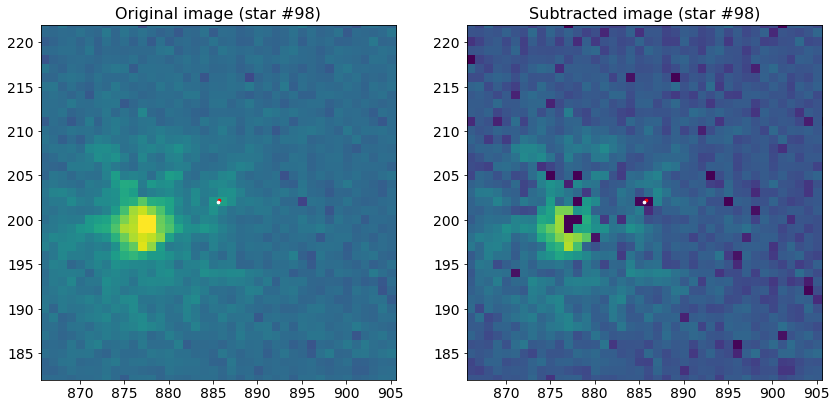

In [38]:
# these *should* be one by itself and one near the core.  But you might 
# have to change the (10, 500) to something else depending on what you
# want to inspect
print(results['flux_fit'].argmax())
for i in (25, 34, 54, 62, 76, 80, 98): 

    resulti = results[i]
    window_rad = 20

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(viz(im1))
    ax1.set_xlim(resulti['x_fit']-window_rad, resulti['x_fit']+window_rad)
    ax1.set_ylim(resulti['y_fit']-window_rad, resulti['y_fit']+window_rad)
    ax1.scatter([resulti['x_0']], [resulti['y_0']], color='r',s=7)
    ax1.scatter([resulti['x_fit']], [resulti['y_fit']], color='w',s=7)
    ax1.set_title('Original image (star #{})'.format(i))

    ax2.imshow(viz(res_im1))
    ax2.set_xlim(resulti['x_fit']-window_rad, resulti['x_fit']+window_rad)
    ax2.set_ylim(resulti['y_fit']-window_rad, resulti['y_fit']+window_rad)
    ax2.scatter([resulti['x_0']], [resulti['y_0']], color='r',s=7)
    ax2.scatter([resulti['x_fit']], [resulti['y_fit']], color='w',s=7)
    ax2.set_title('Subtracted image (star #{})'.format(i))

OK, so the faint objects look OK. Bright ones, not so much. Part of the issue is the attempt to subtract multiple spurious sources from the wings of bright stars.

In [39]:
import sys
import astropy
import scipy
print('Versions:')
print('  python: ', sys.version_info)
print('  astropy: ', astropy.__version__)
print('  scipy: ', scipy.__version__)

#Works with
#Versions:
#  python:  sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
#  astropy:  1.2.1
#  scipy:  0.18.0

Versions:
  python:  sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)
  astropy:  1.3
  scipy:  0.19.0
